# Filtro de partículas


Cada partícula vai ser representada por uma lista [x,y,theta]

Trabalhe com 2 listas:

	S = []  # Vai conter as n partículas. 

	W = [] # Pesos das partículas

	n_part = # Número de partículas


# Atividades


1. Crie uma função que gere n partículas aleatórias distribuidas uniformemente dentro de uma área minx, miny, maxx, maxy (passados como parâmetros). Veja a funcao 

	Devolve uma lista com n partículas

2. Descubra como desenhar as n partículas (analise o módulo inspercles)

3. Faça o desenho das partículas

4. Crie uma lista para simular os movimentos do robô. Veja a lista chamada <code>movimentos</code> que é usada na seção *Teste de animação*, mais abaixo

5. Crie uma função que aplica um deslocamento [delta_x, delta_y, delta_theta] com um desvio padrão [std_x, std_y, std_theta] a todas as partículas

6. Desenhe as partículas após o deslocamento

7. Descubra como calcular $P(D|H)$ analisando o Python Notebook. A função que traça os raios está no modulo inspercles

Programe a aplicação da equação que está na pág. 853 do livro do Norvig $$P(z_t | x_t) = \alpha \prod_{j}^M{e^{\frac{-(z_j - \hat{z_j})}{2\sigma^2}}}$$

Ou seja, para cada raio estimado $\hat{z_j}$ e leitura real $z_j$ calcule a probabilidade daquele raio ter acontecido dado que a posição do robô fosse de fato a da partícula


8 . Usando os resultados de 7 calcule $P(H|D)$ e insira numa lista de probabilidades das partículas

9 . Reamostre as partículas de forma proporcional à probabilidade



In [1]:
from random import randint, choice
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import random
from pf import Particle
from nav_msgs.msg import OccupancyGrid
from occupancy_field import OccupancyField
from helper_functions import angle_normalize, angle_diff

import cv2

import sys
import os
os.getcwd() 
import sys
sys.path.append(os.getcwd())


import inspercles
reload(inspercles)


# Para suprimir alguns warnings do Matplotlib Inline
import warnings
warnings.simplefilter('ignore')
%matplotlib inline


## Diretõrio de trabalho

In [2]:
!pwd




/home/borg/Documentos/robotica17/particle_filter/jupyter_particle


In [3]:
# Dados do arquivo mapa.yaml

resolution = 0.020000
origin =  [-5.000000, -5.000000, 0.000000]
occupied_thresh = 0.8
free_thresh =  0.2

inspercles.free_thresh = free_thresh # Limiar em tons de cinza para que uma celula seja considerada livre
inspercles.occupied_thresh = occupied_thresh # Limiar de celula ocupada
inspercles.origin = origin
inspercles.resolution = resolution


In [4]:


from PIL import Image as PilImage


color_image = cv2.imread("sparse_obstacles.png")
pil_image = color_image
np_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)


#color_image = PilImage.open("sparse_obstacles.png", 'r')
#pil_image = color_image.convert('1') # Converte a imagem PIL para Grayscale
#np_image = np.asarray(pil_image)

particle_size = 10

#import matplotlib_render as plotmap


back_color = "black"
colors     = ['red', 'green', 'cyan', 'yellow']
width, height = 775, 746

inspercles.width = width
inspercles.height = height




initial_pose = [200, 200, math.pi/8] # Posicao inicial considerada para o pf
inspercles.initial_pose = initial_pose
pose = [330, 220, math.radians(90)] # posicao "verdadeira" do robo 
inspercles.pose = pose
robot_radius=10   # Raio do robo
inspercles.robot_radius = robot_radius


# Os angulos em que o robo simulado vai ter sensores
angles = np.linspace(0.0, 2*math.pi, num=8)

particle_cloud = []



    
    
        

### Exercício 1
Criando lista aleátoria de partículas

In [5]:

W = [] # Pesos das partículas

n_part = 100

def gerador_particulas_aleatorias(n_part,minx,maxx,miny,maxy):  #Função que retorna a lista de partículas
    S = []  # Vai conter as n partículas. 
    for i in range(n_part):
        particulas=[]
        particulas.append(random.randint(minx,maxx))
        particulas.append(random.randint(miny,maxy))
        particulas.append(random.uniform(0,2*math.pi))
        p=Particle(particulas[0],particulas[1],particulas[2])
        S.append(p)
    return (S)


## Mapa com posição inicial

### Exercício 2,3

In [6]:
particulas=gerador_particulas_aleatorias(200,0,700,0,700)

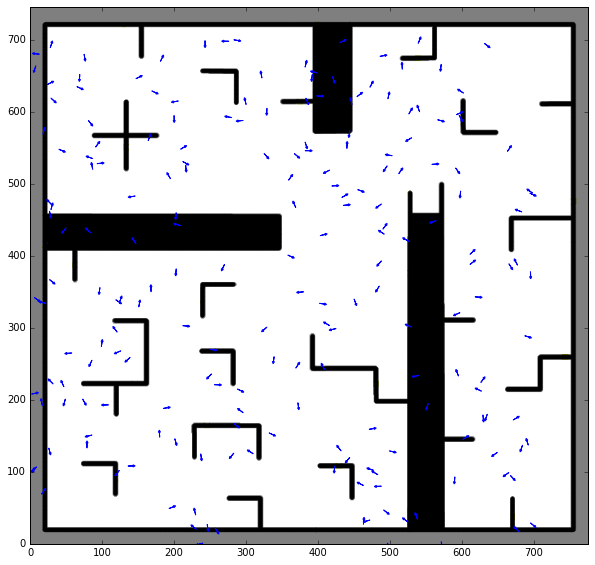

In [7]:
inspercles.nb_draw_map(color_image, particulas)

A função *nb_initialize_particle_cloud()* pertence ao módulo <code>inspercles</code> e já faz uma primeira aleatorização das partículas

In [8]:
# Inicializa as particulas
particulas_miranda = inspercles.nb_initialize_particle_cloud()

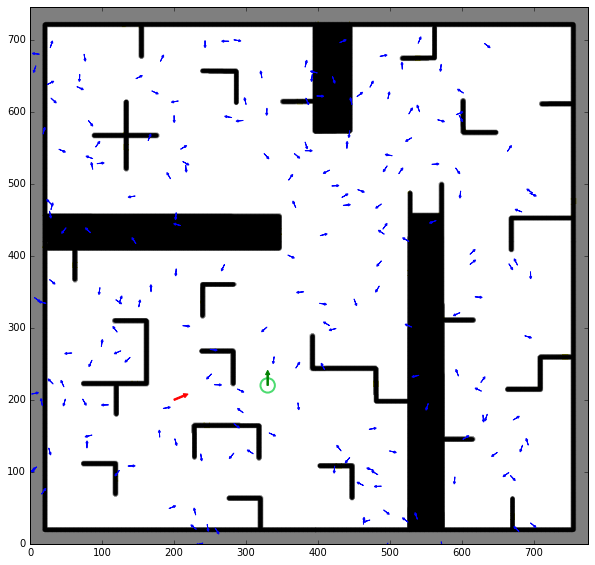

In [9]:
inspercles.nb_draw_map(color_image, particles = particulas, initial_position = initial_pose, pose=pose, robot=True)

In [10]:
angles

array([ 0.        ,  0.8975979 ,  1.7951958 ,  2.6927937 ,  3.5903916 ,
        4.48798951,  5.38558741,  6.28318531])

# Simulação da imagem do laser

Para simular a leitura **real** do robo, use *nb_simulate_lidar* passando a posição real do robô, os ângulos do sensor e a np_image com o mapa

In [11]:
leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)


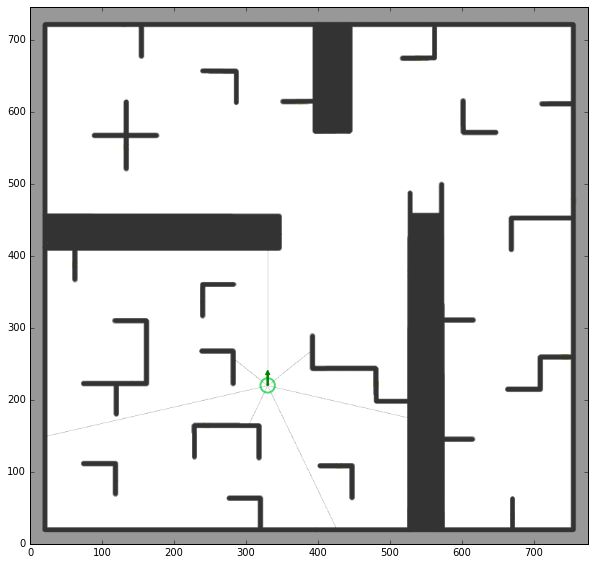

In [12]:
ax = inspercles.nb_draw_map(lidar_map, robot=True, pose=pose)
ax.imshow(color_image, alpha=0.8)
#nb_draw_map(occupancy_image)

As leituras serao retornadas pela simulacao do lidar. Sao armazenadas na forma de um dicionario com angulo: valor da leitura

In [13]:
# As predicoes teoricas das leituras
leituras

{0.0: 202.2325394193526,
 0.89759790102565518: 82.76472678623425,
 1.7951958020513104: 193.13207915827965,
 2.6927937030769655: 171.40011668607463,
 3.5903916041026207: 364.77116114078973,
 4.4879895051282759: 161.40012391568973,
 5.3855874061539311: 78.81624198095213,
 6.2831853071795862: 202.2325394193526}

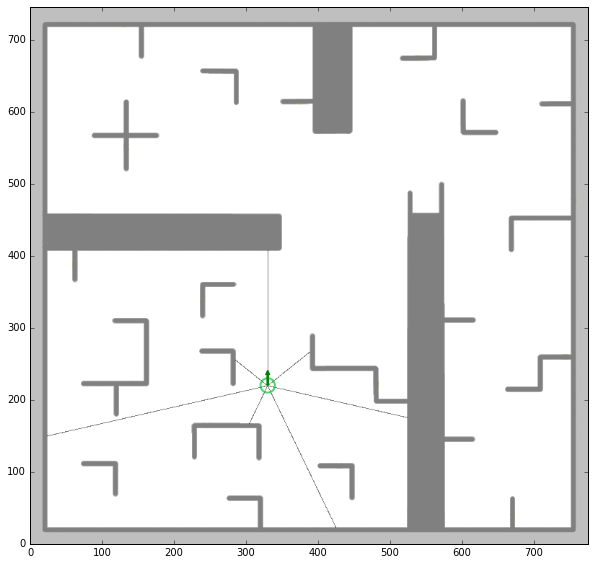

In [14]:
ax = inspercles.nb_draw_map(lidar_map, pose=pose, robot=True)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(pil_image, alpha=0.5)

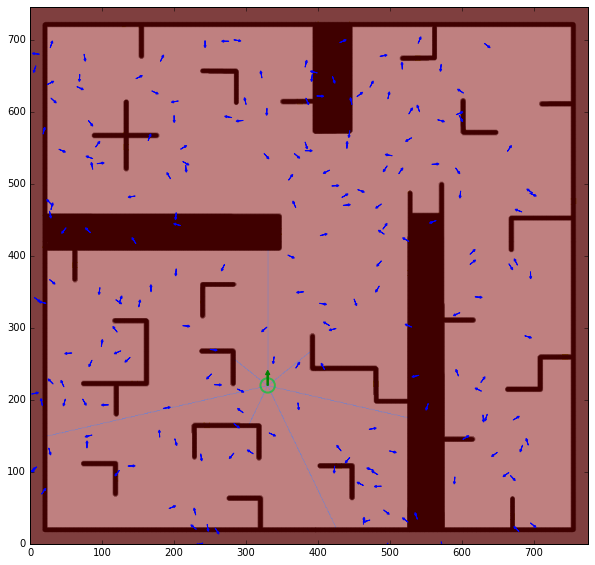

In [15]:
ax = inspercles.nb_draw_map(pil_image, pose=pose, robot=True, particles=particulas)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(lidar_map, alpha=0.5)

## Gerando uma animação

### Exercício 4

In [16]:
# Coloque nesta lista os deslocamentos do robo

movimentos = [[-10, -10, 0], [-10, 10, 0], [-10,0,0], [-10, 0, 0],
              [0,0,math.pi/12.0], [0, 0, math.pi/12.0], [0, 0, math.pi/12],[0,0,-math.pi/4],
              [-5, 0, 0],[-5,0,0], [-5,0,0], [-10,0,0],[-10,0,0], [-10,0,0],[-10,0,0],[-10,0,0],[-15,0,0],
              [0,0,-math.pi/4],[0, 10, 0], [0,10,0], [0, 10, 0], [0,10,0], [0,0,math.pi/8], [0,10,0], [0,10,0], 
              [0,10,0], [0,10,0], [0,10,0],[0,10,0],
              [0,0,-math.radians(90)],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0]
              
              ]


Exercício 5

In [17]:
"""
def deslocamento_particulas (movimentos, std_x, std_y, std_theta):
    deslocamentos=[]
    for deslocamento in movimentos:
        desl=[]
        deslocamento_x = 
        deslocamento_y = deslocamento[1]
        deslocamento_theta = deslocamento[2]
        deslocamento_x += deslocamento[0] + np.random.randint(0, std_x)
        deslocamento_y += deslocamento[1] + np.random.randint(0, std_y)
        deslocamento_theta += deslocamento[2] + np.random.randint(0, std_theta)
        desl.append(deslocamento_x)
        desl.append(deslocamento_y)
        desl.append(deslocamento_theta)
        deslocamentos.append(desl)
        
    return deslocamentos
"""

'\ndef deslocamento_particulas (movimentos, std_x, std_y, std_theta):\n    deslocamentos=[]\n    for deslocamento in movimentos:\n        desl=[]\n        deslocamento_x = \n        deslocamento_y = deslocamento[1]\n        deslocamento_theta = deslocamento[2]\n        deslocamento_x += deslocamento[0] + np.random.randint(0, std_x)\n        deslocamento_y += deslocamento[1] + np.random.randint(0, std_y)\n        deslocamento_theta += deslocamento[2] + np.random.randint(0, std_theta)\n        desl.append(deslocamento_x)\n        desl.append(deslocamento_y)\n        desl.append(deslocamento_theta)\n        deslocamentos.append(desl)\n        \n    return deslocamentos\n'

In [18]:
#movidas = deslocamento_particulas(random_particles,movimentos,10,5,math.pi/6)

In [19]:
"""def convert_to_particles(xy_theta_list):
    particles = []
    for e in xy_theta_list:
        particles.append(Particle(e[0], e[1], e[2]))
    return particles

parts = convert_to_particles(movidas)
"""

'def convert_to_particles(xy_theta_list):\n    particles = []\n    for e in xy_theta_list:\n        particles.append(Particle(e[0], e[1], e[2]))\n    return particles\n\nparts = convert_to_particles(movidas)\n'

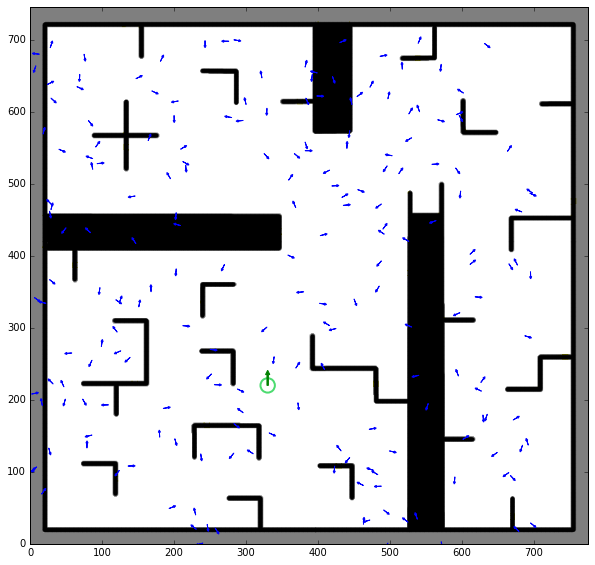

In [20]:

#inspercles.nb_draw_particle_cloud(convert_to_particles(movidas), ax)

ax = inspercles.nb_draw_map(color_image, pose=pose, robot=True, particles=particulas)


### Exercício 5,6

In [21]:

plt.ioff() # Desliga o modo interativo, para nao aparecerem muitas imagens no meio

frames = 1

for delta in movimentos:
    for i in range(len(pose)):
        pose[i]+=delta[i]
    for p in particulas:
        std_x = 10
        std_y = 5
        std_theta = math.pi/6
        p.x += delta[0] + np.random.randint(0, std_x)
        p.y += delta[1] + np.random.randint(0, std_y)
        p.theta += delta[2] + np.random.randint(0, std_theta)
    
    # Simula a leitura do lidar
    leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)

    # Desenha as particulas
    ax = inspercles.nb_draw_map(color_image, pose=pose, robot=True, particles=particulas)
    
    #ax.imshow(occupancy_image, alph.2)
    # Desenha o mapa do lidar
    ax.imshow(lidar_map, alpha=0.5)

    plt.savefig("anim%04d.png"%frames, bounds="tight")
    
    frames+=1
    plt.close('all')


plt.ion()



Para gerar os gifs é preciso ter o pacote *imagemagick*

O imagemagick pode ser obtido com o seguinte comando:
    sudo apt-get install imagemagick 
    
Agora vamos invocar na linha de comando o seguinte comando:
    convert -delay 10 -loop 1 anim*png animated.gif
    
Este comando criou um arquivo chamado *animated.fig*, que leremos abaixo:
    

In [22]:
!convert -delay 10 -loop 1 anim*png animated.gif

Infelizmente o IPython Notebook 2 nao parece exibir animacoes em Gif por default, mas voce pode abrir o arquivo no diretorio de trabalho e devera'  ve-lo.

<img src="animated.gif">

![](anim.gif)

### Exercício 7